In [3]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
import os
import pandas as pd
import sklearn.decomposition
from sklearn.model_selection import train_test_split
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
############################################################
####################
TRAINING_STEPS = 1000 #50000
embedding_dim = 64 #depth of 1D conv matrix
batch_size = 64
learning_rate = .0001
zdim = 32 #size of gaussian noise
nfilt = 64 #width of convolutions and layers
MAX_LENGTH = 128 #max length of conditions
NULL_TOKEN = '~'

####################
############################################################

In [5]:
Dataset1_Smiles_P = pd.read_csv("dataset1_imputed_all.csv")
Dataset1_Smiles_P

,index,Name,PID,Smiles,Details,Condition,Reference,Year,He,H2,...,log10_O2_Bayesian,log10_N2_Bayesian,log10_CO2_Bayesian,log10_CH4_Bayesian,log10_He_Etree,log10_H2_Etree,log10_O2_Etree,log10_N2_Etree,log10_CO2_Etree,log10_CH4_Etree
0,0,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,NaN,...,0.531479,-0.075721,1.110590,0.012254,1.201301,1.238196,0.531479,-0.075721,1.110590,-0.103039
1,1,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,NaN,...,0.429002,-0.191294,1.037426,-0.101212,0.512792,0.845879,0.372675,-0.111720,1.037426,0.361122
2,2,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,NaN,...,-0.665546,-1.367414,-0.066764,-1.348410,0.803205,0.693273,-0.665546,-1.412270,-0.130830,-1.517954
3,3,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,NaN,...,-0.327902,-1.004516,0.274628,-0.963282,0.696047,0.613919,-0.327902,-1.146430,0.327439,-1.337536
4,4,polyethene,P010001,*C*,NaN,"25 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,1.77,NaN,...,-0.013228,-0.490133,0.826281,-0.003425,0.247973,0.794222,-0.013228,-0.606161,0.774200,-0.306994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,313,Poly(2-adamanthyl vinyl ether),NaN,C(C(OC1C3CC2CC1CC(C2)C3)*)*,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,NaN,...,0.778874,0.227887,1.401401,0.360861,1.035338,1.350877,0.778874,0.227887,1.401401,0.498163
774,314,Poly(benzyl vinyl ether),NaN,C(C(OCC1=CC=CC=C1)*)*,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,NaN,...,0.367356,-0.102373,1.045323,0.067094,0.506273,0.849116,0.367356,-0.102373,1.045323,0.359446
775,315,Poly(cyclohexylmethyl vinyl ether),NaN,C(C(OCC1CCCCC1)*)*,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,NaN,...,0.190332,-0.397940,0.770115,-0.314109,0.966260,0.943327,0.190332,-0.397940,0.770115,-0.114003
776,316,Poly(8-tricyclo[5.2.1.0]decylmethyl vinyl ether),NaN,C(C(OCC1CC2C3C(C1C2)CCC3)*)*,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,NaN,...,-0.091515,-0.886057,0.454845,-0.901289,0.922455,1.046136,-0.091515,-0.886057,0.454845,-1.037802


In [7]:
smiles = Dataset1_Smiles_P['Smiles']
START_TOKEN = '?'
END_TOKEN = '!'
    
V = sorted(set(''.join(smiles.unique().tolist())))
V.append(END_TOKEN)
V.append(NULL_TOKEN)
V.append(START_TOKEN)
vocab_dim = len(V)

['#',
 '%',
 '(',
 ')',
 '*',
 '-',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'B',
 'C',
 'F',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'i',
 'l',
 'n',
 'o',
 'r',
 's',
 '!',
 '~',
 '?']

In [7]:
smiles_ = [np.array([V.index(c) for c in s] + [V.index(END_TOKEN)]).astype(np.int32) for s in smiles]
smilesdf = pd.DataFrame(smiles_, index=smiles.index)
smilesdf

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
0,5,20,5,48,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,20,5,48,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,20,5,48,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,20,5,48,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,20,5,48,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,20,3,20,3,25.0,20.0,9.0,20.0,11.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,20,3,20,3,25.0,20.0,20.0,9.0,18.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,20,3,20,3,25.0,20.0,20.0,9.0,20.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
778,20,3,20,3,25.0,20.0,20.0,9.0,20.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
smilesdf = smilesdf.fillna(value=V.index(NULL_TOKEN))
smilesdf

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
0,5,20,5,48,49.0,49.0,49.0,49.0,49.0,49.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
1,5,20,5,48,49.0,49.0,49.0,49.0,49.0,49.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
2,5,20,5,48,49.0,49.0,49.0,49.0,49.0,49.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
3,5,20,5,48,49.0,49.0,49.0,49.0,49.0,49.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
4,5,20,5,48,49.0,49.0,49.0,49.0,49.0,49.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,20,3,20,3,25.0,20.0,9.0,20.0,11.0,20.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
776,20,3,20,3,25.0,20.0,20.0,9.0,18.0,20.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
777,20,3,20,3,25.0,20.0,20.0,9.0,20.0,20.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
778,20,3,20,3,25.0,20.0,20.0,9.0,20.0,20.0,...,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0


In [7]:
permdf = Dataset1_Smiles_P.iloc[:,-6:]
permdf

,log10_He_Etree,log10_H2_Etree,log10_O2_Etree,log10_N2_Etree,log10_CO2_Etree,log10_CH4_Etree
0,-9.090993,0.898821,0.973384,0.531479,-0.075721,1.110590
1,-9.424129,0.568279,0.864289,0.397940,-0.136783,1.037426
2,-9.393129,0.613290,0.786125,-0.665546,-1.320905,0.007831
3,-9.436574,0.567867,1.086332,-0.327902,-0.955102,0.264110
4,-9.752027,0.247973,0.571909,-0.013228,-0.678901,0.421806
...,...,...,...,...,...,...
570,-6.858750,4.983416,5.381121,4.963599,4.447158,5.670799
571,-9.011887,0.988113,0.908485,-0.207608,-0.970616,0.346353
572,-6.870572,4.971594,5.370190,4.937718,4.442323,5.651830
573,-8.339801,1.662955,1.858716,0.981819,0.437751,1.673203


In [8]:
split = False
if split:
    conditions_train, conditions_eval, expressions_train, expressions_eval = train_test_split(smilesdf, permdf, 
                                                    test_size=0.2, 
                                                    random_state=2)
else:
    conditions_train = smilesdf
    expressions_train = permdf
    conditions_eval = pd.DataFrame()
    expressions_eval = pd.DataFrame()
    
#print(conditions_train.shape)
#print(expressions_train.shape)
#print(conditions_eval.shape)
#print(expressions_eval.shape)

In [9]:
#############################################
#############################################
##### tf graph
class Loader(object):
    """A Loader class for feeding numpy matrices into tensorflow models."""

    def __init__(self, data, labels=None, shuffle=False):
        """Initialize the loader with data and optionally with labels."""
        self.start = 0
        self.epoch = 0
        self.data = [x for x in [data, labels] if x is not None]
        self.labels_given = labels is not None

        if shuffle:
            self.r = list(range(data.shape[0]))
            np.random.shuffle(self.r)
            self.data = [x[self.r] for x in self.data]

    def next_batch(self, batch_size=100):
        """Yield just the next batch."""
        num_rows = self.data[0].shape[0]

        if self.start + batch_size < num_rows:
            batch = [x[self.start:self.start + batch_size] for x in self.data]
            self.start += batch_size
        else:
            self.epoch += 1
            batch_part1 = [x[self.start:] for x in self.data]
            batch_part2 = [x[:batch_size - (x.shape[0] - self.start)] for x in self.data]
            batch = [np.concatenate([x1, x2], axis=0) for x1, x2 in zip(batch_part1, batch_part2)]

            self.start = batch_size - (num_rows - self.start)

        if not self.labels_given:  # don't return length-1 list
            return batch[0]
        else:  # return list of data and labels
            return batch

    def iter_batches(self, batch_size=100):
        """Iterate over the entire dataset in batches."""
        num_rows = self.data[0].shape[0]

        end = 0

        if batch_size > num_rows:
            if not self.labels_given:
                yield [x for x in self.data][0]
            else:
                yield [x for x in self.data]
        else:
            for i in range(num_rows // batch_size):
                start = i * batch_size
                end = (i + 1) * batch_size

                if not self.labels_given:
                    yield [x[start:end] for x in self.data][0]
                else:
                    yield [x[start:end] for x in self.data]
            if end < num_rows:
                if not self.labels_given:
                    yield [x[end:] for x in self.data][0]
                else:
                    yield [x[end:] for x in self.data]

def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky ReLU activation."""
    return tf.maximum(x, leak * x)

def nameop(op, name):

    return tf.identity(op, name=name)

def minibatch(input_, num_kernels=15, kernel_dim=10, name='',):
    """Add minibatch features to input."""
    with tf.variable_scope(name):
        W = tf.get_variable('{}/Wmb'.format(name), [input_.get_shape()[-1], num_kernels * kernel_dim])
        b = tf.get_variable('{}/bmb'.format(name), [num_kernels * kernel_dim])

    x = tf.matmul(input_, W) + b
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_mean(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_mean(tf.exp(-abs_diffs), 2)

    return tf.concat([input_, minibatch_features], axis=-1)

def build_config(limit_gpu_fraction=0.2, limit_cpu_fraction=10):
    if limit_gpu_fraction > 0:
        # os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=limit_gpu_fraction)
        config = tf.ConfigProto(gpu_options=gpu_options)
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        config = tf.ConfigProto(device_count={'GPU': 0})
    if limit_cpu_fraction is not None:
        if limit_cpu_fraction <= 0:
            # -2 gives all CPUs except 2
            cpu_count = min(
                1, int(os.cpu_count() + limit_cpu_fraction))
        elif limit_cpu_fraction < 1:
            # 0.5 gives 50% of available CPUs
            cpu_count = min(
                1, int(os.cpu_count() * limit_cpu_fraction))
        else:
            # 2 gives 2 CPUs
            cpu_count = int(limit_cpu_fraction)
        config.inter_op_parallelism_threads = cpu_count
        config.intra_op_parallelism_threads = cpu_count
        os.environ['OMP_NUM_THREADS'] = str(1)
        os.environ['MKL_NUM_THREADS'] = str(cpu_count)
    return config

def bn(tensor, name, is_training):
    # return tensor
    # return tf.contrib.layers.batch_norm(tensor, is_training=is_training, scale=True, decay=0.9, updates_collections=None, scope=name, reuse=tf.AUTO_REUSE)
    return tf.layers.batch_normalization(tensor,
                      momentum=.9,
                      training=is_training,
                      name=name)
    # return tf.keras.layers.BatchNormalization(momentum=.9)(tensor, is_training)

def Generator(z, cond, nfilt, outdim, activation=lrelu, is_training=True):
    h1 = tf.layers.dense(z, nfilt * 4, activation=None, name='h1')
    h1 = bn(h1, 'h1', is_training)
    h1 = activation(h1)

    h2 = tf.layers.dense(h1, nfilt * 2, activation=None, name='h2')
    h2 = bn(h2, 'h2', is_training)
    h2 = activation(h2)

    h3 = tf.layers.dense(h2, nfilt * 1, activation=None, name='h3')
    h3 = bn(h3, 'h3', is_training)
    h3 = activation(h3)

    h1_cond = tf.layers.dense(cond, nfilt * 4, activation=None, name='h1_cond')
    h1_cond = bn(h1_cond, 'h1_cond', is_training)
    h1_cond = activation(h1_cond)

    h2_cond = tf.layers.dense(h1_cond, nfilt * 2, activation=None, name='h2_cond')
    h2_cond = bn(h2_cond, 'h2_cond', is_training)
    h2_cond = activation(h2_cond)

    h3_cond = tf.layers.dense(h2_cond, nfilt * 1, activation=None, name='h3_cond')
    h3_cond = bn(h3_cond, 'h3_cond', is_training)
    h3_cond = activation(h3_cond)

    h3 = tf.concat([h3, h3_cond], axis=-1)

    h4 = tf.layers.dense(h3, nfilt * 2, activation=None, name='h4')
    h4 = bn(h4, 'h4', is_training)
    h4 = lrelu(h4)
    h4 = tf.concat([h4, h2, h2_cond], axis=-1)

    h5 = tf.layers.dense(h4, nfilt * 4, activation=None, name='h5')
    h5 = bn(h5, 'h5', is_training)
    h5 = lrelu(h5)
    h5 = tf.concat([h5, h1, h1_cond], axis=-1)

    out = tf.layers.dense(h5, outdim, activation=None, name='out')

    return out

def Embedder(x, nfilt, outdim, activation=lrelu, is_training=True):
    h1 = tf.layers.dense(x, nfilt * 4, activation=None, name='h1')
    h1 = bn(h1, 'h1', is_training)
    h1 = activation(h1)

    h2 = tf.layers.dense(h1, nfilt * 2, activation=None, name='h2')
    h2 = bn(h2, 'h2', is_training)
    h2 = activation(h2)

    h3 = tf.layers.dense(h2, nfilt * 1, activation=None, name='h3')
    h3 = bn(h3, 'h3', is_training)
    h3 = activation(h3)

    out = tf.layers.dense(h3, outdim, activation=None, name='out')

    return out

def Discriminator(x, cond, nfilt, outdim, activation=lrelu, is_training=True):
    h1 = tf.layers.dense(x, nfilt * 8, activation=None, name='h1')
    h1 = activation(h1)
    h1 = minibatch(h1)

    h1_cond = tf.layers.dense(cond, nfilt * 8, activation=None, name='h1_cond')
    h1_cond = activation(h1_cond)
    h1_cond = minibatch(h1_cond)

    h1 = tf.concat([h1, h1_cond], axis=-1)

    h2 = tf.layers.dense(h1, nfilt * 4, activation=None, name='h2')
    h2 = bn(h2, 'h2', is_training)
    h2 = activation(h2)

    h3 = tf.layers.dense(h2, nfilt * 2, activation=None, name='h3')
    h3 = bn(h3, 'h3', is_training)
    h3 = activation(h3)

    h4 = tf.layers.dense(h3, nfilt * 1, activation=None, name='h4')
    h4 = bn(h4, 'h4', is_training)
    h4 = activation(h4)

    out = tf.layers.dense(h4, outdim, activation=None, name='out')

    return out

def adversarial_loss(logits, labels):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    # return tf.reduce_mean((logits - labels)**2)

def preprocess_batch(batch_x, batch_cond):
    batch_max_size = MAX_LENGTH
    batch_cond = batch_cond[:, :batch_max_size]
    batch_cond = np.where(np.isnan(batch_cond), V.index(NULL_TOKEN), batch_cond)

    return batch_x, batch_cond

In [10]:
####################
############################################################
#reduces the dimension of the response variable to 15 dimensions, no necessary for gas permeability (6 dimensions)
reducedim = False

if reducedim:
    pcadim = 15
    pca = sklearn.decomposition.PCA(pcadim)
    pca.fit(np.concatenate([expressions_train, expressions_eval], axis=0))
    pcadata_train = pca.transform(expressions_train)
    pcadata_eval = pca.transform(expressions_eval)
    loadtrain = Loader(pcadata_train, conditions_train.values, shuffle=True)
    loadtrain_unshuffled = Loader(pcadata_train, conditions_train.values, shuffle=False)
    loadeval = Loader(pcadata_eval, conditions_eval.values, shuffle=False)
else:
    loadtrain = Loader(expressions_train.values, conditions_train.values, shuffle=True)
    loadtrain_unshuffled = Loader(expressions_train.values, conditions_train.values, shuffle=False)
    loadeval = Loader(expressions_eval.values, conditions_eval.values, shuffle=False)
outdim = loadtrain.data[0].shape[1]


#############################################
#############################################

In [11]:
tf.reset_default_graph()
tfis_training = tf.placeholder(tf.bool, [], name='tfis_training')


G_mult = 1
D_mult = 4
##################################################

condition = tf.placeholder(tf.int32, [None, MAX_LENGTH], name='condition')

#embed the generator condition
embedding_G = tf.Variable(tf.random_normal((vocab_dim, embedding_dim), 0, .1), name='generator/embedding')
embedding_input_G = tf.nn.embedding_lookup(embedding_G, condition)
with tf.variable_scope('generator_condition', reuse=tf.AUTO_REUSE):
    h1 = tf.layers.conv1d(embedding_input_G, 64 * G_mult, 3, strides=4, padding='same', name='conv1')
    h1 = bn(h1, 'conv1', tfis_training)
    h1 = lrelu(h1)

    h2 = tf.layers.conv1d(h1, 32 * G_mult, 3, strides=4, padding='same', name='conv2')
    h2 = bn(h2, 'conv2', tfis_training)
    h2 = lrelu(h2)

    h3 = tf.layers.conv1d(h2, 16 * G_mult, 3, strides=4, padding='same', name='conv3')
    h3 = bn(h3, 'conv3', tfis_training)
    h3 = lrelu(h3)

    pre_embedding_condition_G = tf.reshape(h3, [tf.shape(h3)[0], MAX_LENGTH // 64 * 16 * G_mult])

    embedded_condition_G = Embedder(pre_embedding_condition_G, nfilt * G_mult, outdim=128, is_training=tfis_training)
    embedded_condition_G = nameop(embedded_condition_G, 'embedded_condition_G')

#embed the discriminator condition
embedding_D = tf.Variable(tf.random_normal((vocab_dim, embedding_dim), 0, .1), name='discriminator/embedding')
embedding_input_D = tf.nn.embedding_lookup(embedding_D, condition)
with tf.variable_scope('discriminator_condition', reuse=tf.AUTO_REUSE):
    h1 = tf.layers.conv1d(embedding_input_D, 64 * D_mult, 3, strides=4, padding='same', name='conv1')
    h1 = bn(h1, 'conv1', tfis_training)
    h1 = lrelu(h1)

    h2 = tf.layers.conv1d(h1, 32 * D_mult, 3, strides=4, padding='same', name='conv2')
    h2 = bn(h2, 'conv2', tfis_training)
    h2 = lrelu(h2)

    h3 = tf.layers.conv1d(h2, 16 * D_mult, 3, strides=4, padding='same', name='conv3')
    h3 = bn(h3, 'conv3', tfis_training)
    h3 = lrelu(h3)

    pre_embedding_condition_D = tf.reshape(h3, [tf.shape(h3)[0], MAX_LENGTH // 64 * 16 * D_mult])

    embedded_condition_D = Embedder(pre_embedding_condition_D, nfilt * D_mult, outdim=128, is_training=tfis_training)
    embedded_condition_D = nameop(embedded_condition_D, 'embedded_condition_D')

##################################################

C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\legacy_tf_layers\convolutional.py:202: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  warnings.warn('`tf.layers.conv1d` is deprecated and '
C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.

In [12]:
##################################################
#forward propogate to calculate the loss in the discriminator and generator
z = tf.placeholder(tf.float32, [None, zdim], name='z')

with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
    G = Generator(z, embedded_condition_G, nfilt * G_mult, outdim, is_training=tfis_training)
    G = nameop(G, 'G')

x = tf.placeholder(tf.float32, [None, outdim], name='x')
with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
    real = Discriminator(x, embedded_condition_D, nfilt=nfilt * D_mult, outdim=1, is_training=tfis_training)
    fake = Discriminator(G, embedded_condition_D, nfilt=nfilt * D_mult, outdim=1, is_training=tfis_training)

loss_D = .5 * tf.reduce_mean(adversarial_loss(logits=real, labels=tf.ones_like(real)))
loss_D += .5 * tf.reduce_mean(adversarial_loss(logits=fake, labels=tf.zeros_like(fake)))
loss_G = tf.reduce_mean(adversarial_loss(logits=fake, labels=tf.ones_like(fake)))

update_ops_D = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if 'discriminator' in op.name]
update_ops_G = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if 'generator' in op.name]

print('update ops G: {}'.format(len(update_ops_G)))
print('update ops D: {}'.format(len(update_ops_D)))

#train with the adam optimizer for gradient descent
with tf.control_dependencies(update_ops_D):
    optD = tf.train.AdamOptimizer(learning_rate)
    train_op_D = optD.minimize(loss_D, var_list=[tv for tv in tf.trainable_variables() if 'discriminator' in tv.name])
with tf.control_dependencies(update_ops_G):
    optG = tf.train.AdamOptimizer(learning_rate)
    train_op_G = optG.minimize(loss_G, var_list=[tv for tv in tf.trainable_variables() if 'generator' in tv.name])
##################################################

update ops G: 28
update ops D: 24


In [13]:
##################################################


#use the config that was built above in this class, and the defined graph structure
sess = tf.Session(config=build_config(limit_gpu_fraction=.1))

#initialize tensorflow session once with the variables that were defined
sess.run(tf.global_variables_initializer())


#############################################

100 (24.394 s): LossD: 0.318 LossG: 1.266 
200 (19.125 s): LossD: 0.327 LossG: 1.427 
300 (20.277 s): LossD: 0.435 LossG: 1.162 
400 (20.494 s): LossD: 0.329 LossG: 1.413 
500 (23.717 s): LossD: 0.446 LossG: 1.254 
600 (24.690 s): LossD: 0.306 LossG: 1.389 
700 (28.998 s): LossD: 0.283 LossG: 1.488 
800 (27.493 s): LossD: 0.212 LossG: 1.855 
900 (28.025 s): LossD: 0.201 LossG: 1.966 
1000 (26.887 s): LossD: 0.309 LossG: 1.552 


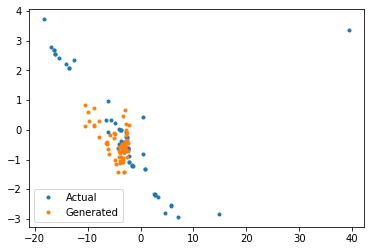

In [14]:
#############################################

#loop through the training with a predefined number of epochs
t = time.time()
training_counter = 0
while training_counter < TRAINING_STEPS + 1:
    training_counter += 1
    batch_x, batch_cond = loadtrain.next_batch(batch_size)
    batchz = np.random.normal(0, 1, [batch_size, zdim])

    batch_x, batch_cond_ = preprocess_batch(batch_x, batch_cond)

    feed = {x: batch_x, condition: batch_cond_, z: batchz, tfis_training: True}
    #run the tensorflow training optimizers on the generator and discriminator
    sess.run(train_op_G, feed_dict=feed)
    sess.run(train_op_D, feed_dict=feed)

    #run the tensorflow training based on the losses on the generator and discriminator
    if training_counter % 100 == 0:
        ld, lg = sess.run([loss_D, loss_G], feed_dict=feed)
        print("{} ({:.3f} s): LossD: {:.3f} LossG: {:.3f} ".format(training_counter, time.time() - t, ld, lg))
        t = time.time()
    
        if training_counter % 1000 == 0:
            # run the given training data through the model
            # a train-test split is generally not necessary, so train generally refers to all datapoints
            traindata = [] #actual permeability data
            trainconditions = [] # conditions that accompany the permeability data
            trainpreds = [] # generated permeability data
            trainembconditions = [] # learned condition embeddings
            for i, (batch_x, batch_cond) in enumerate(loadtrain.iter_batches(batch_size)):
                batchz = np.random.normal(0, 1, [batch_x.shape[0], zdim])

                batch_x, batch_cond_ = preprocess_batch(batch_x, batch_cond)

                feed = {x: batch_x, condition: batch_cond_, z: batchz, tfis_training: False}

                preds = sess.run(G, feed_dict=feed)
                embconds = sess.run(embedded_condition_G, feed_dict=feed)

                traindata.append(batch_x)
                trainconditions.append(batch_cond)
                trainpreds.append(preds)
                trainembconditions.append(embconds)
            traindata = np.concatenate(traindata, axis=0)
            trainconditions = np.concatenate(trainconditions, axis=0)
            trainpreds = np.concatenate(trainpreds, axis=0)
            trainembconditions = np.concatenate(trainembconditions, axis=0)

            #pca = PCA(n_components=2)
            #transformed = pca.fit_transform(traindata)
            #plt.plot(transformed[:,0], transformed[:,1], '.')
            #transformed = pca.fit_transform(trainpreds)
            #plt.plot(transformed[:,0], transformed[:,1], '.')
            #plt.legend(['Actual', 'Generated'])
            #plt.show()
            
            trainconditions_df = pd.DataFrame(trainconditions)
            polymer_cond = smilesdf.iloc[0,:] #choose a polymer from the original dataframe, 0 index is polyethylene
            polymer_indices = trainconditions_df.where(trainconditions_df == polymer_cond).dropna().index

            pca = PCA(n_components=2)
            transformed = pca.fit_transform(traindata)
            plt.plot(transformed[polymer_indices,0], transformed[polymer_indices,1], '.')
            transformed = pca.fit_transform(trainpreds)
            plt.plot(transformed[polymer_indices,0], transformed[polymer_indices,1], '.')
            plt.legend(['Actual', 'Generated'])
            plt.show()

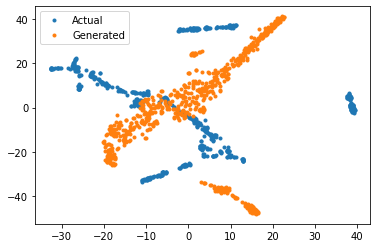

In [15]:
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(traindata)
plt.plot(transformed[:,0], transformed[:,1], '.')
transformed = tsne.fit_transform(trainpreds)
plt.plot(transformed[:,0], transformed[:,1], '.')
plt.legend(['Actual', 'Generated'])

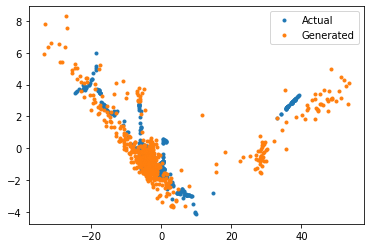

In [16]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(traindata)
plt.plot(transformed[:,0], transformed[:,1], '.')
transformed = pca.fit_transform(trainpreds)
plt.plot(transformed[:,0], transformed[:,1], '.')
plt.legend(['Actual', 'Generated'])
plt.show()

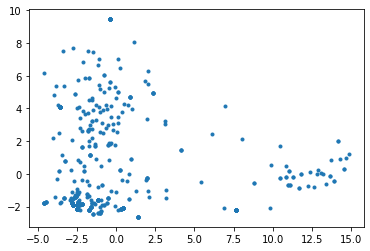

In [24]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(trainembconditions)
plt.plot(transformed[:,0], transformed[:,1], '.')

In [18]:
polymer_indices

Int64Index([ 26,  32,  34,  37,  50,  60,  61,  76,  79,  95,  99, 176, 188,
            190, 191, 193, 199, 204, 205, 212, 225, 227, 234, 240, 242, 245,
            249, 251, 255, 260, 266, 301, 307, 335, 338, 350, 352, 359, 380,
            392, 399, 411, 416, 434, 442, 457, 461, 466, 468, 469, 472, 487,
            490, 493, 521, 531, 535, 540, 543, 571],
           dtype='int64')

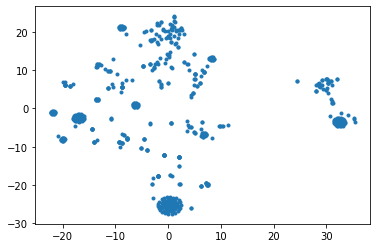

In [25]:
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(trainembconditions)
plt.plot(transformed[:,0], transformed[:,1], '.')